# Syllable conditioned GAN training

In [ ]:
from transformers import BartTokenizer, BartModel,BartForConditionalGeneration
from torch.distributions import Categorical
import pandas as pd
import torch.nn as nn
from undecorated import undecorated
import numpy as np
from datasets import load_metric
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader
from transformers import  Seq2SeqTrainingArguments, Seq2SeqTrainer,DataCollatorForSeq2Seq
metric = load_metric("rouge")
import torch.optim as optim
import torchvision.utils as vutils
import types
import matplotlib.pyplot as plt
from torch.distributions import Categorical
import random
#from torch.linalg import norm

In [ ]:
from gan_utils import get_end_mask,get_valid_mask,Discriminator,discriminator_train_standard, generate_random_input_syllables,reinforce_loss_syllables,Generator


In [ ]:
from utils import PoemDataset,encode_sentences_wsyl

In [ ]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
#generator = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

# Construct syllable dictionary


every random input will have syllables 5-7-5 (+1,0) (some noise so discriminator hopefully wont learn just this, and because real data has some noise)

In [ ]:
#here im making a dictionary of all tokens and their associated syllable count
from nltk.tokenize import SyllableTokenizer
syllable_dict = {}
for token in range(50265):
    syl_tokenizer = SyllableTokenizer()
    t = torch.tensor(token)
    #print(tokenizer.decode(t),len(syl_tokenizer.tokenize(tokenizer.decode(t).strip())))
    syllable_dict[token] = len(syl_tokenizer.tokenize(tokenizer.decode(t).strip()))
syllable_dict[0] = 0
syllable_dict[2] = 0
syllable_dict[1] = 0
syllable_dict[50118] = 0

In [19]:
#(logprob[0])

In [16]:
#(tokens[0])

In [17]:
#g = Generator().cuda()

# Data


In [ ]:
def syllable_vec(row):
    return [row['line_0_scount'],row['line_1_scount'],row['line_2_scount']]

def change_title(row):
    #adds syllable info to title
    #print(row['Title'])
    return str(row['syllables']) + ';' + str(row['Title'])

def add_syllables_title(part_df, match_df):
    merged = pd.merge(part_df, match_df,how='left', left_on=['Unnamed: 0'], right_index=True)
    merged['syllables'] = merged.apply(syllable_vec,axis=1)
    merged.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y','line_0','line_1','line_2','source','valid','line_0_scount',
                        'line_1_scount','line_2_scount'],inplace=True)
    merged['Title'] = merged.apply(change_title,axis=1)
    
    return merged

In [ ]:
processed_data_dir =  '/home/alexander/nlg-project/data/'
test_df = pd.read_csv(processed_data_dir + 'test_data.csv')
train_df = pd.read_csv(processed_data_dir + 'train_data.csv')
whole_df = pd.read_csv(processed_data_dir + 'kaggle_data.csv')


train_df = add_syllables_title(train_df,whole_df)
test_df = add_syllables_title(test_df,whole_df)

test_model = encode_sentences_wsyl(tokenizer,test_df)


train_model = encode_sentences_wsyl(tokenizer,train_df)

In [26]:
#logprob

In [ ]:
class PoemDataset_syl(Dataset):
    def __init__(self, df):
        self.labels = df['labels']
        self.mask = df['attention_mask']
        self.input = df['input_ids']
        self.syllables = df['syllables']
        #self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        input_ids = self.input[idx]
        attention_masks = self.mask[idx]
        target_ids = self.labels[idx]
        syllables = self.syllables[idx]
        batch = {
          "input_ids": input_ids,
          "decoder_attention_mask": torch.tensor([1] * 128),
          "attention_mask": attention_masks,
          "label_ids": target_ids,
          "syllables":syllables
        }
        return batch

In [ ]:
train_ds = PoemDataset_syl(train_model)
eval_ds = PoemDataset_syl(test_model)

In [28]:
#discriminator = discriminator.cuda()

# Train

In [ ]:
PATH = '/home/alexander/nlg-project/GAN_models_syllables/'

In [ ]:
 #reduced to a binary problem 
bsize = 12
generator =  Generator().cuda()#BartForConditionalGeneration.from_pretrained('facebook/bart-base').cuda()
#model = TheModelClass(*args, **kwargs)
#generator.load_state_dict(torch.load(PATH + 'generator.pt')['model_state_dict'])
discriminator = Discriminator().cuda()
discriminator.load_state_dict(torch.load(PATH + 'discriminator.pt')['model_state_dict'])
criterion = nn.BCEWithLogitsLoss(reduction='none')

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = generate_random_input_syllables(bsize,'cuda')

# Establish convention for real and fake labels during training
real_label = 1.
ewma_reward = 0.0#torch.tensor(0.0)
fake_label = 0.
lr = .000001
beta1 = .9
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(discriminator.parameters(), lr=lr*.05, betas=(beta1, 0.99)) 
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.99))

In [33]:
#fixed_noise

In [34]:
#out.sequences

In [29]:
#sample losses towards end of training

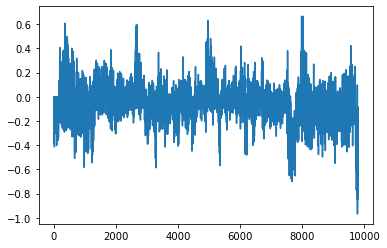

In [41]:
plt.plot(G_losses)

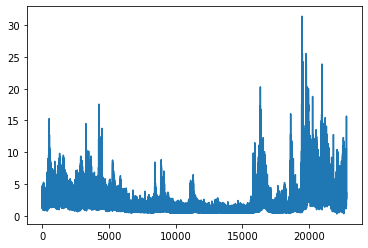

In [37]:
plt.plot(D_losses)

In [ ]:
with open("G_losses_5_5_syl.txt", "w") as f:
    for s in G_losses:
        f.write(str(s) +"\n")

In [ ]:
# Training Loop
device = 'cuda'

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 30

train_dl = DataLoader(train_ds,batch_size=bsize,num_workers=2)
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    print("Label Noise:",0.05*.9**epoch)
    # For each batch in the dataloader
    for i, data in enumerate(train_dl, 0):
       # print(i)
        
        if len(data['input_ids']) < bsize:
            continue
       # print(data)
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        
        # Format batch
        real_inputs = data['input_ids'].to(device)
        real_input_attention = data['attention_mask'].to(device)
        real_input_test = {'input_ids':real_inputs,'attention_mask':real_input_attention}
        
        
        real_gpu = data['label_ids'].to(device)
        attention_gpu = data['decoder_attention_mask'].to(device)
        b_size = real_gpu.size(0)
        #
        label = torch.full((b_size,), 1.0 , dtype=torch.float, device=device) #.95 instead of real to inject noise
        label = torch.bernoulli(label)
       # print(label)
        # Forward pass real batch through D
        real_mask = get_valid_mask(real_gpu)

        output_real,loss_real = discriminator_train_standard(discriminator,real_gpu[:,1:],label,criterion,mask=real_mask)

        loss_real.backward()

        #del label
        #output = discriminator(real_gpu,attention_mask=attention_gpu).view(-1)
        # Calculate loss on all-real batch
        #errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        #errD_real.backward()
        D_x = output_real.detach().mean().item()
        #del output_real
        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise,noise_syl = generate_random_input_syllables(bsize,device)#torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        #print(fake)
       # print(noise)
        if random.random() > .5:
            titles = noise['input_ids']
            syllables = noise_syl
            fake,fake_logprobs = generator(noise)
        else:
            titles = real_input_test['input_ids']
            syllables = data['syllables']
            #sometimes the discirminator learns words in real input, this way some will be based on these same words
            fake,fake_logprobs = generator(real_input_test)
            #real_input_test

        fake_mask = get_valid_mask(fake)
        end_mask = get_end_mask(fake)
  
        #generate_sequence(generator,noise)
       # print(len(fake_logprobs))
        #a = 1/0
        #fake = generator.generate_with_grad(noise['input_ids'].cuda(),attention_mask=noise["attention_mask"].cuda()) #,max_length=128
       # print(fake)
        #print((fake.logits))
        #fake = decode(fake.logits)
      #  print(fake)
        # I am injecting some false positives into the fake labels so the discriminator does a worse job
        label.fill_(0.0) 
        label = torch.bernoulli(label)
       # print(label)
        # Classify all fake batch with D
        output_fake,loss_fake = discriminator_train_standard(discriminator,fake,label,criterion,mask=fake_mask)

        loss_fake.backward()
       # print('fake')
       # print(loss_fake.detach())
        #output = discriminator(fake).view(-1)
        # Calculate D's loss on the all-fake batch
        #errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
       # errD_fake.backward()
        D_G_z1 = output_fake.detach().cpu().mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = (torch.mean(loss_real.detach()) + torch.mean(loss_fake.detach())).cpu()
       # del output_real
        # Update D
        optimizerD.step()
        

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        


        lossG, cumulative_rewards, ewma_reward = reinforce_loss_syllables(output_fake,fake_logprobs,.3,.08,epoch,fake_mask,end_mask,syllables,fake,ewma_reward,syllable_dict)
        if i % (1024*4) == 0:
            print('Disc LogProbs True')
            print(output_real[0:1])
            print('Disc LogProbs False')
            print(output_fake[0:1])
            print('gen loss')
            print(lossG[0:1])
            print('cum rewards')
            print(cumulative_rewards[0:1])
            print('gen logprobs')
            print(fake_logprobs[0:1])
            print(tokenizer.batch_decode(fake[0:1].cpu()))

        #print(lossG)
        lossG = torch.mean(lossG)
       # print(lossG)
        #print(loss)
        #label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
       # print(fake)
        #output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        #errG = criterion(output, label)
        #print(errG)
        #errG = loss.detach()
        # Calculate gradients for G
        lossG.backward()
        D_G_z2 = lossG.detach().cpu().mean().item()
        # Update G
        
        optimizerG.step()
        generator.zero_grad()
        discriminator.zero_grad()
        #a = 1/0
        # Output training stats
        if i % 256 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_dl),
                     errD.item(), lossG.item(), D_x, D_G_z1, D_G_z2))
          #  print('ewma_reward:',ewma_reward)

        # Save Losses for plotting later
        G_losses.append(lossG.detach().item())
        D_losses.append(errD.detach().item())
        
        del lossG

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 1000 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = tokenizer.batch_decode(generator.model.generate(fixed_noise[0]['input_ids'],attention_mask=fixed_noise[0]["attention_mask"],max_length=32,num_beams= 50,early_stopping = True))
                print(fake[0:2])
        if (iters % 1000 == 0 and iters != 0):
            print('saving geneartor')
            torch.save({
            'epoch': 15,
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': optimizerG.state_dict(),
            'loss': 0.3355,
            }, PATH + 'generator.pt')
            torch.save({
            'epoch': 15,
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': optimizerD.state_dict(),
            'loss': 0.3355,
            }, PATH + 'discriminator.pt')
            #img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
Label Noise: 0.05


<ipython-input-18-2ea912393255>:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output_tokens = torch.cat([output_tokens,torch.tensor(next_word).unsqueeze(1)],axis=1)
/home/alexander/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
<ipython-input-17-0f424487d694>:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  syl_diff = torch.tensor(desired_syllables - running_syllables,dtype=torch.int32).cuda()


Disc LogProbs True
tensor([[3.8895, 3.7554, 3.9745, 4.2929, 4.0554, 4.7351, 4.8642, 4.9528, 4.9829,
         4.9843, 4.9728, 5.0016, 5.0026, 5.1074, 5.0888, 5.0904, 5.1139, 5.1421,
         5.1209, 5.1313, 5.0131]], device='cuda:0', grad_fn=<SliceBackward>)
Disc LogProbs False
tensor([[ 1.3536,  1.1512,  0.0761, -0.1045, -0.7076, -0.8751, -0.6863, -1.2499]],
       device='cuda:0', grad_fn=<SliceBackward>)
gen loss
tensor([[ 2.7256e-02,  1.0229e-02,  2.6341e-03,  2.1473e-03, -1.0808e-03,
         -1.3198e-02,  4.3744e-02,  2.1865e-06]], device='cuda:0',
       grad_fn=<SliceBackward>)
cum rewards
tensor([[ 0.5894,  0.6753,  0.0528, -0.0739, -0.4841, -0.5876,  0.5283,  0.3745]],
       device='cuda:0', grad_fn=<SliceBackward>)
gen logprobs
tensor([[-3.4585e-02, -1.1703e-02, -1.0473e-02, -1.7218e-02, -3.7861e-03,
         -3.3934e-02, -6.0177e-02, -3.8147e-06]], device='cuda:0',
       grad_fn=<SliceBackward>)
[' mother thanks yourself from this day that</s>']
[0/30][0/11403]	Loss_D: 4.9

[1/30][256/11403]	Loss_D: 2.9765	Loss_G: -0.0567	D(x): 3.2158	D(G(z)): -3.2815 / -0.0567
[1/30][512/11403]	Loss_D: 2.4729	Loss_G: -0.0071	D(x): 1.7732	D(G(z)): -4.4836 / -0.0071


# del optimizerG

In [33]:
torch.save({
            'epoch': 15,
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': optimizerG.state_dict(),
            'loss': 0.3355,
            }, PATH + '5_it_syl_generator.pt')
torch.save({
            'epoch': 15,
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': optimizerD.state_dict(),
            'loss': 0.3355,
            }, PATH + '5_it_syl_discriminator.pt')

<All keys matched successfully>

In [32]:
inputs = tokenizer("cats", return_tensors="pt")

In [35]:
tokenizer.batch_decode(test_generator.model.eval().cpu().generate(inputs['input_ids'],attention_mask=inputs["attention_mask"],max_length=128, use_cache=True,
        decoder_start_token_id = tokenizer.pad_token_id,
        num_beams= 50,
        early_stopping = True, max_length=16))

SyntaxError: keyword argument repeated (<ipython-input-35-f3e261162407>, line 5)

In [ ]:
inputs = tokenizer("echidna", return_tensors="pt")

In [ ]:
tokenizer.batch_decode(BartForConditionalGeneration.from_pretrained('BART-base/checkpoint-25000').eval().cpu().generate(inputs['input_ids'],attention_mask=inputs["attention_mask"],max_length=128, use_cache=True,
        decoder_start_token_id = tokenizer.pad_token_id,                 
        num_beams= 50,
        early_stopping = True))

# Test 

In [ ]:
batch_size = 16 

args = Seq2SeqTrainingArguments(
    "BART-base",
    evaluation_strategy = "epoch",
    #learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
   # weight_decay=0.01,
   # save_total_limit=3,
   # num_train_epochs=1,
   # predict_with_generate=True,
    
    learning_rate=1e-4,
    weight_decay=0.01,
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-6,
    max_grad_norm=1.0,
    num_train_epochs=10,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
   # label_names="labels",
    #fp16=True,
  #  use_auth_token=False
    #push_to_hub=True,
)

In [ ]:
#train_ds = PoemDataset(model_input)
trainer = Seq2SeqTrainer(
    model=BartForConditionalGeneration.from_pretrained('BART-base/checkpoint-25000'),
    args=args,
   # data_collator=data_collator,
    train_dataset=train_ds,
    
    eval_dataset=eval_ds,
    #use_auth_token=False,
    
    tokenizer=tokenizer
)

In [ ]:
trainer.evaluate()

In [ ]:
pwd

In [ ]:
mkdir GAN_models

In [ ]:
torch.save({
            'epoch': 15,
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': optimizerG.state_dict(),
            'loss': 0.3355,
            }, PATH + 'generator.pt')

In [ ]:
torch.save({
            'epoch': 15,
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': optimizerD.state_dict(),
            'loss': 0.3355,
            }, PATH + 'discriminator.pt')

In [ ]:
pwd

In [ ]:
cd GAN_models